In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
images_dir = '/content/drive/My Drive/transfer_learning/recognize_emotions_in_faces/images/'

In [3]:
classes = os.listdir(images_dir)
count_classes = len(classes)
classes

['Neutral', 'Happy', 'Fear', 'Disgust', 'Angry']

In [4]:
total = 0
dict={}
for folder in os.listdir(images_dir):
  c_total = len(os.listdir(images_dir+folder))
  dict[folder]=c_total
  total = total+c_total
print('count images in each class ', dict)
print('total images: ', total)


count images in each class  {'Neutral': 4295, 'Happy': 6838, 'Fear': 2541, 'Disgust': 380, 'Angry': 2836}
total images:  16890


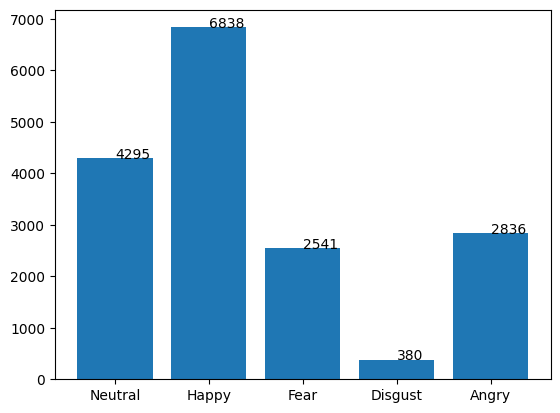

In [5]:
import matplotlib.pyplot as plt
import numpy as np

classes = list(dict.keys())
classes_count = list(dict.values())

for i in range(len(classes)):
  plt.text(i, classes_count[i], classes_count[i])

plt.bar(range(len(dict)), classes_count, tick_label=classes)
plt.show()

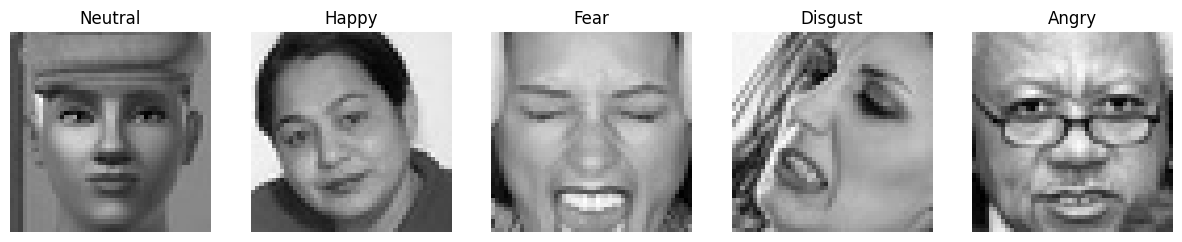

In [6]:
from PIL import Image

fig, axs = plt.subplots(1, len(classes), figsize=(15, 3))
for i, class_name in enumerate(classes):
  class_images = os.listdir(os.path.join(images_dir, class_name))
  img_path = os.path.join(images_dir, class_name, class_images[0])
  img = Image.open(img_path)
  axs[i].imshow(img, cmap='gray')
  axs[i].set_title(class_name)
  axs[i].axis('off')

plt.show()

In [7]:
Image_Height = 48
Image_Width = 48

target_size = (Image_Height, Image_Width)

In [8]:
image_files = []
labels = []

for root, dirs, files in os.walk(images_dir):
  for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png')):
        image_files.append(os.path.join(root, file))
        labels.append(os.path.basename(root))

print(image_files[0])
print(labels[0])

/content/drive/My Drive/transfer_learning/recognize_emotions_in_faces/images/Neutral/Training_66984209.jpg
Neutral


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.2, random_state=42)

In [10]:
def load_and_preprocess_image(image_path, target_size):
  img = Image.open(image_path)
  img = img.convert('RGB') if img.mode != 'RGB' else img
  img = img.resize(target_size)
  img_array = np.array(img) / 255.0
  return img

In [ ]:
X_train_processed = np.array([load_and_preprocess_image(img_path, target_size) for img_path in X_train])
X_test_processed = np.array([load_and_preprocess_image(img_path, target_size) for img_path in X_test])

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_test_encoded

In [ ]:
classes_labels=[]
for i in range(count_classes):
  class_label = label_encoder.inverse_transform([i])
  classes_labels.append(class_label[0])
classes_labels

In [ ]:
from keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_test_categorical

In [ ]:
import random
import numpy as np
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [ ]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(Image_Height, Image_Width, 3))

for layer in base_model.layers:
    layer.trainable = False

print("Layers : ", len(base_model.layers))
base_model.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout
from keras.optimizers import Adam

# نموذج تسلسلي
model = Sequential()
# طبقة الدخل
model.add(Input(shape=(Image_Height, Image_Width, 3)))
# إضافة النموذج المدرب
model.add(base_model)
# إضافة طبقة تسطيح
model.add(Flatten())
# طبقة تسريب
model.add(Dropout(0.2))
# طبقة كثيفة
model.add(Dense(128, activation='relu'))
# طبقة تسريب
model.add(Dropout(0.2))
# طبقة كثيفة
model.add(Dense(64, activation='relu'))
# طبقة الخرج
model.add(Dense(count_classes, activation='softmax'))

# تهيئة النموذج
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# طباعة ملخص النموذج
model.summary()

In [ ]:
epochs = 16
history = model.fit(
    X_train_processed,
    y_train_categorical,
    epochs=epochs,
    validation_data=(X_test_processed, y_test_categorical)
)

In [ ]:
score = model.evaluate(X_test_processed, y_test_categorical)
print('Test accuracy:', round(score[1]*100, 2))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
base_model.summary()

In [ ]:
model = Sequential()

model.add(Input(shape=(Image_Height, Image_Width, 3)))

model.add(base_model)

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(count_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(
    X_train_processed,
    y_train_categorical,
    epochs=epochs,
    validation_data=(X_test_processed, y_test_categorical)
)

In [ ]:
score = model.evaluate(X_test_processed, y_test_categorical)
print('Test accuracy:', round(score[1]*100, 2))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
y_pred = model.predict(X_test_processed)
y_pred

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
pred_class_labels = []
for c in y_pred:
    pred_class_labels.append(label_encoder.inverse_transform([c])[0])

pred_class_labels

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_class_labels)
cm

In [ ]:
from sklearn.metrics import  ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()